In [1]:
from collections import Counter
import os

from graphviz import Source
from IPython.display import display, Markdown

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
from graphviz import Source
import networkx as nx

In [3]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    print(root_nodes)
    #assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


# Load clone map

In [5]:
data = pd.read_csv('../../data/YFV2001_clone_key/YFV2001_clone_key', sep = '\t')
data.head()

clones_map_raw = data.copy()
clones_map_raw

,clone,tree_id,cell_id,node_name
0,bulk,s0,P3861_210.txt,ss0
1,107,s10,P1299_1141,ss10
2,107,s54,P1299_1514,ss54
3,107,s55,P1299_1529,ss55
4,107,s56,P1299_1535,ss56
...,...,...,...,...
68,149,s26,P3128_1042,ss26
69,149,s31,P3128_1077,ss31
70,149,s32,P3128_1086,ss32
71,149,s41,P3128_1139,ss41


In [6]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [7]:
all_clones

['bulk', '107', '108', '118', '122', '143', '149']

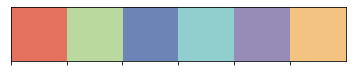

In [8]:
flatui = ['#E5715F', '#BAD99F', '#6C85B6', '#91CFCF', '#978CB7', '#F2C381'] 
sns.palplot(sns.color_palette(flatui))

In [27]:
colors = sns.color_palette(sns.color_palette(flatui))

clone_color = {
    'bulk': (0, 0, 0),
    '107': np.array(colors[0]) * 255,
    '108': np.array(colors[1]) * 255,
    '118': np.array(colors[2]) * 255,
    '122': np.array(colors[3]) * 255,
    '143': np.array(colors[4]) * 255,
    '149': np.array(colors[5]) * 255,
}


In [26]:
clone_color

{'bulk': (0, 0, 0),
 '107.0': array([229., 113.,  95.]),
 '108.0': array([186., 217., 159.]),
 '118.0': array([108., 133., 182.]),
 '122.0': array([145., 207., 207.]),
 '143.0': array([151., 140., 183.]),
 '149.0': array([242., 195., 129.])}

In [28]:
clone_color

{'bulk': (0, 0, 0),
 '107': array([229., 113.,  95.]),
 '108': array([186., 217., 159.]),
 '118': array([108., 133., 182.]),
 '122': array([145., 207., 207.]),
 '143': array([151., 140., 183.]),
 '149': array([242., 195., 129.])}

# Load target tree

In [43]:
tree_filename = f'../../../mt-SCITE/mt-SCITE_output/YFV2001/0.0556/0.0556_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

In [44]:
# tree contains some empty trailing node. Check that it is removed.
print(len(tree.nodes()))
tree.remove_node('\\n')
print(len(tree.nodes()))

528
527


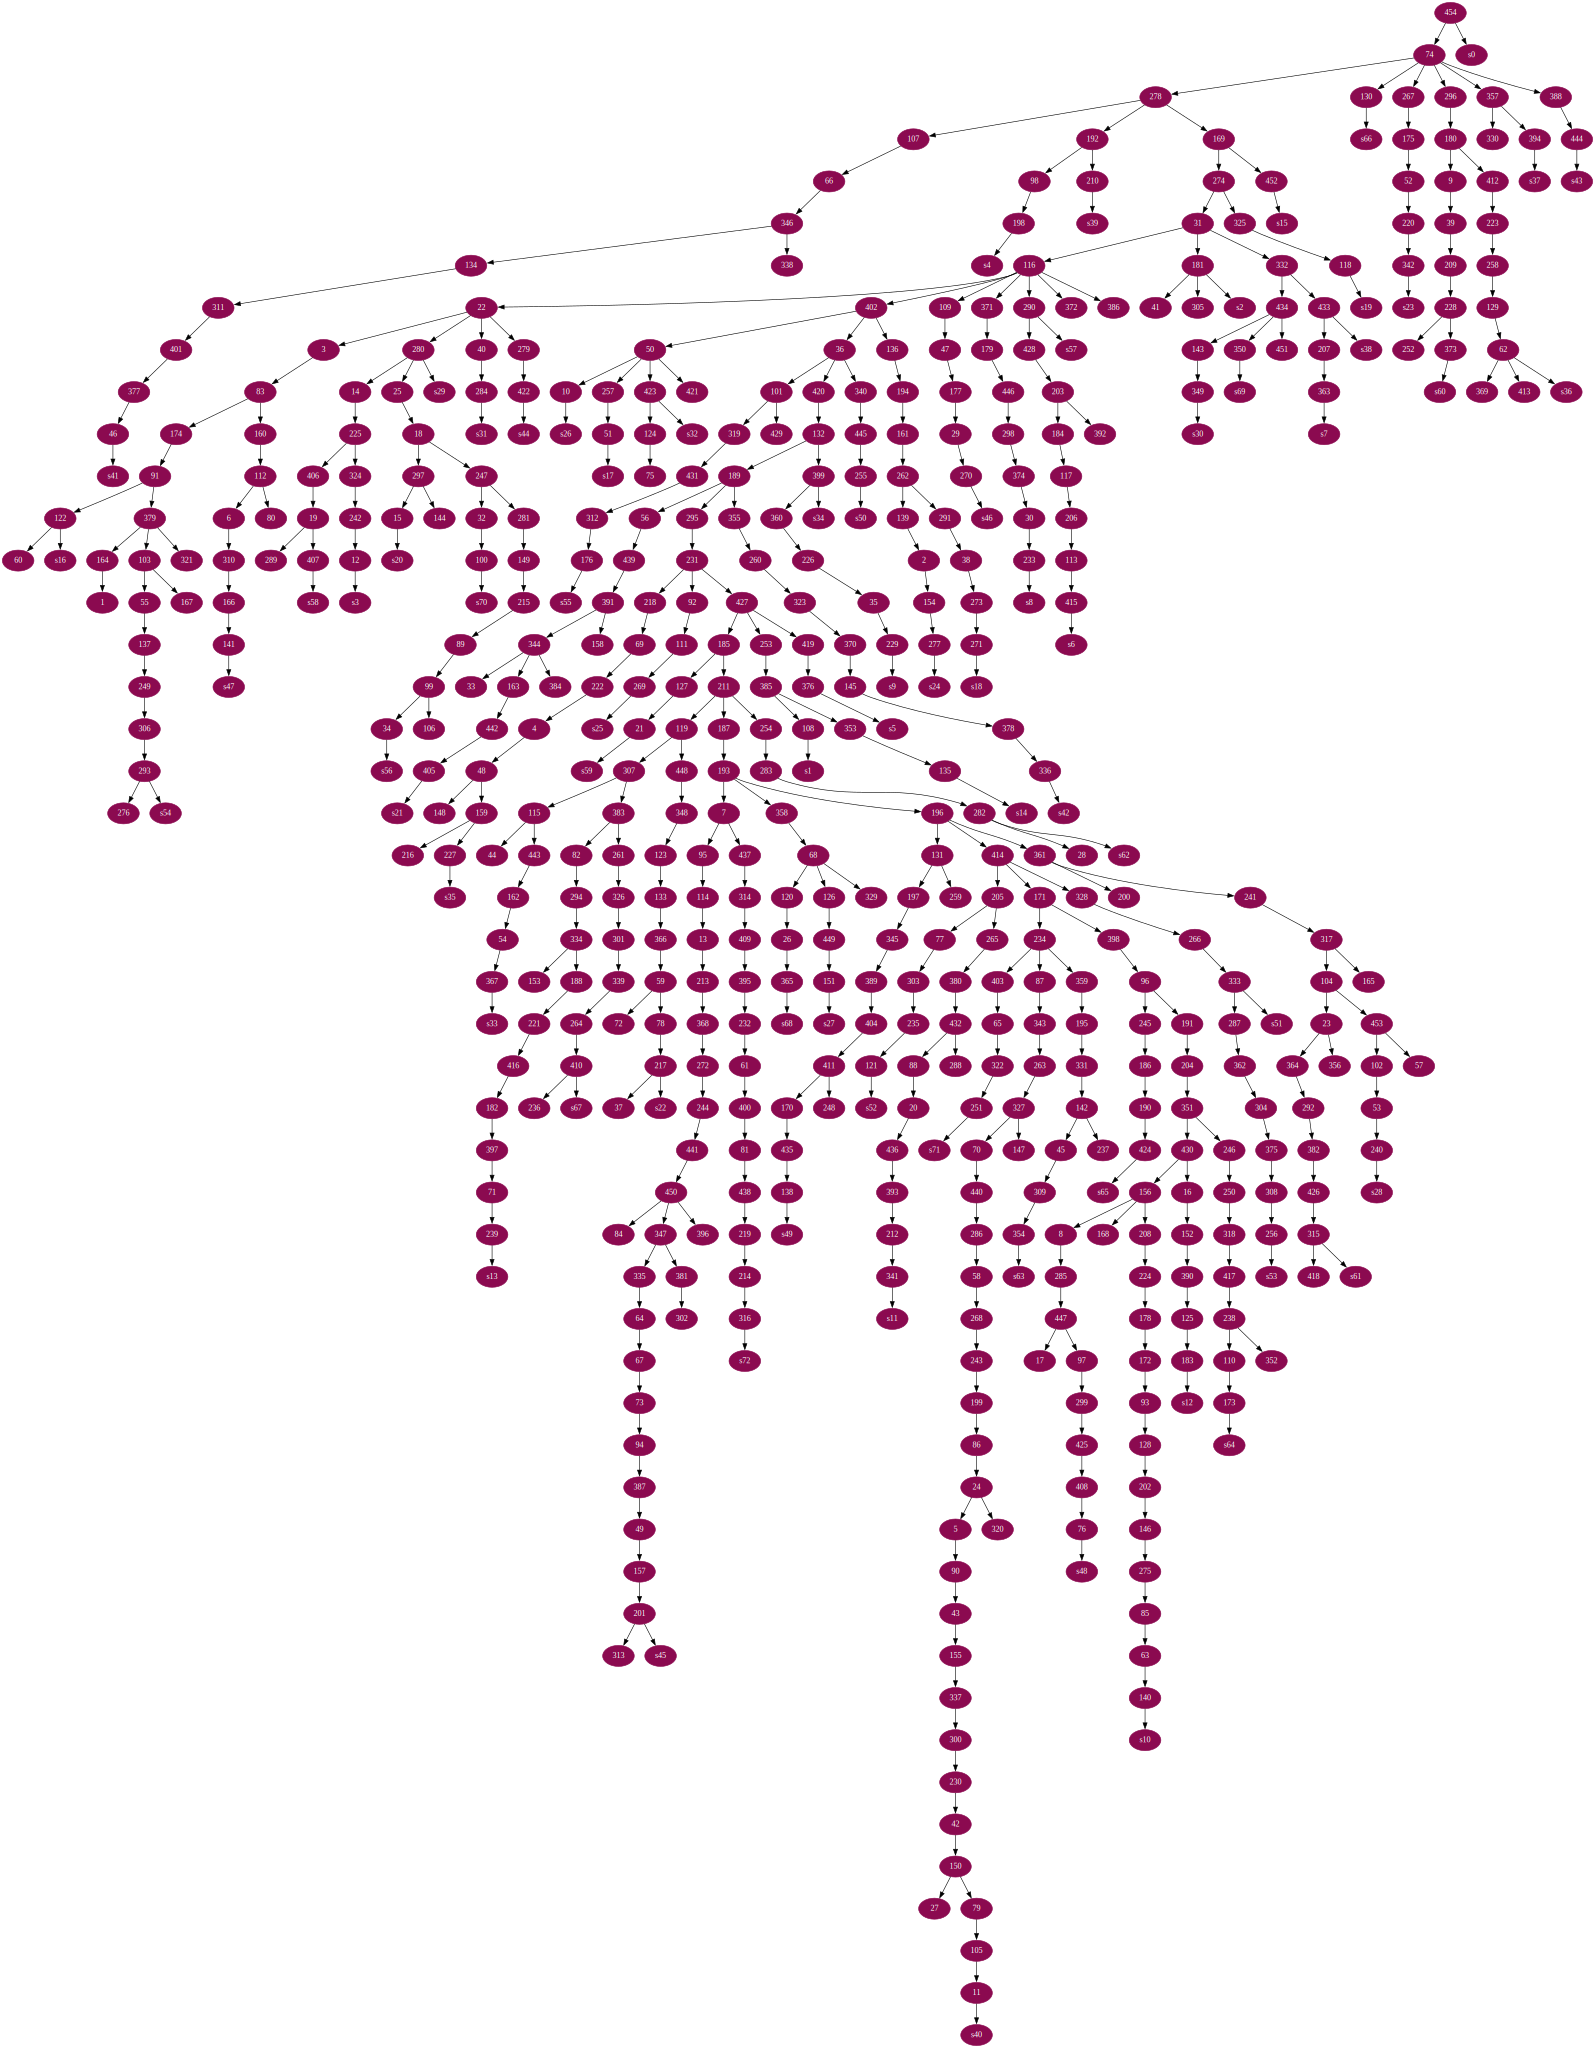

In [45]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

# Decorate the nodes

In [46]:
mix_clones_colors(n, clones_purity)

array([0, 0, 0])

In [47]:
def rgb_to_hex(colortuple):
    return '#' + ''.join(f'{int(i):02X}' for i in colortuple)

def mix_clones_colors(node_name, purities):
    node_purities = purities[node_name]
    color = 0
    for clone, frac in node_purities.iteritems():
        color += frac * np.array(clone_color[clone])
    return color.astype(int)


clones_count = dfs_clones_count(tree, clones_map, all_clones, source_node=get_root_node(tree))
clones_purity = purity(clones_count)

for n in tree.nodes:
    node_dict = tree.nodes[n]
    if n.startswith('s'):
        # This is the style for sample nodes
        clone = clones_map[n]
        node_dict['color'] = rgb_to_hex(clone_color[clone])
        node_dict['shape'] = 'circle' #square
    else:
        if n in clones_purity:
            # This is the style for mutation nodes
            # Color is a mix of purities
            node_dict['color'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
        else:
            # Dangling mutation node
            node_dict['color'] = 'black'

['454']
!! possible mutation in a leaf: not found 338
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 60
!! possible mutation in a leaf: not found 276
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 321
!! possible mutation in a leaf: not found 289
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 392
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 158
!! possible mutation in a leaf: not found 33
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 216


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This

!! possible mutation in a leaf: not found 44
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 236
!! possible mutation in a leaf: not found 72
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 396


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This

!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 200
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 165
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 320


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This

!! possible mutation in a leaf: not found 147
!! possible mutation in a leaf: not found 237
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 17
!! possible mutation in a leaf: not found 168


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This

!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 124


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This

!! possible mutation in a leaf: not found 41
!! possible mutation in a leaf: not found 305
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 413
!! possible mutation in a leaf: not found 330


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_38024/3756212178.py:20: PerformanceWarning: DataFrame is highly fragmented.  This

In [48]:
# Global graph style
tree.graph['node']['shape'] = 'square' #circle
tree.graph['node']['fontcolor'] = 'white'
tree.graph['edges'] = {'arrowsize': '4'}
tree.graph

{'name': 'G',
 'node': {'color': 'deeppink4',
  'style': 'filled',
  'fontcolor': 'white',
  'shape': 'square'},
 'edges': {'arrowsize': '4'}}

In [49]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)

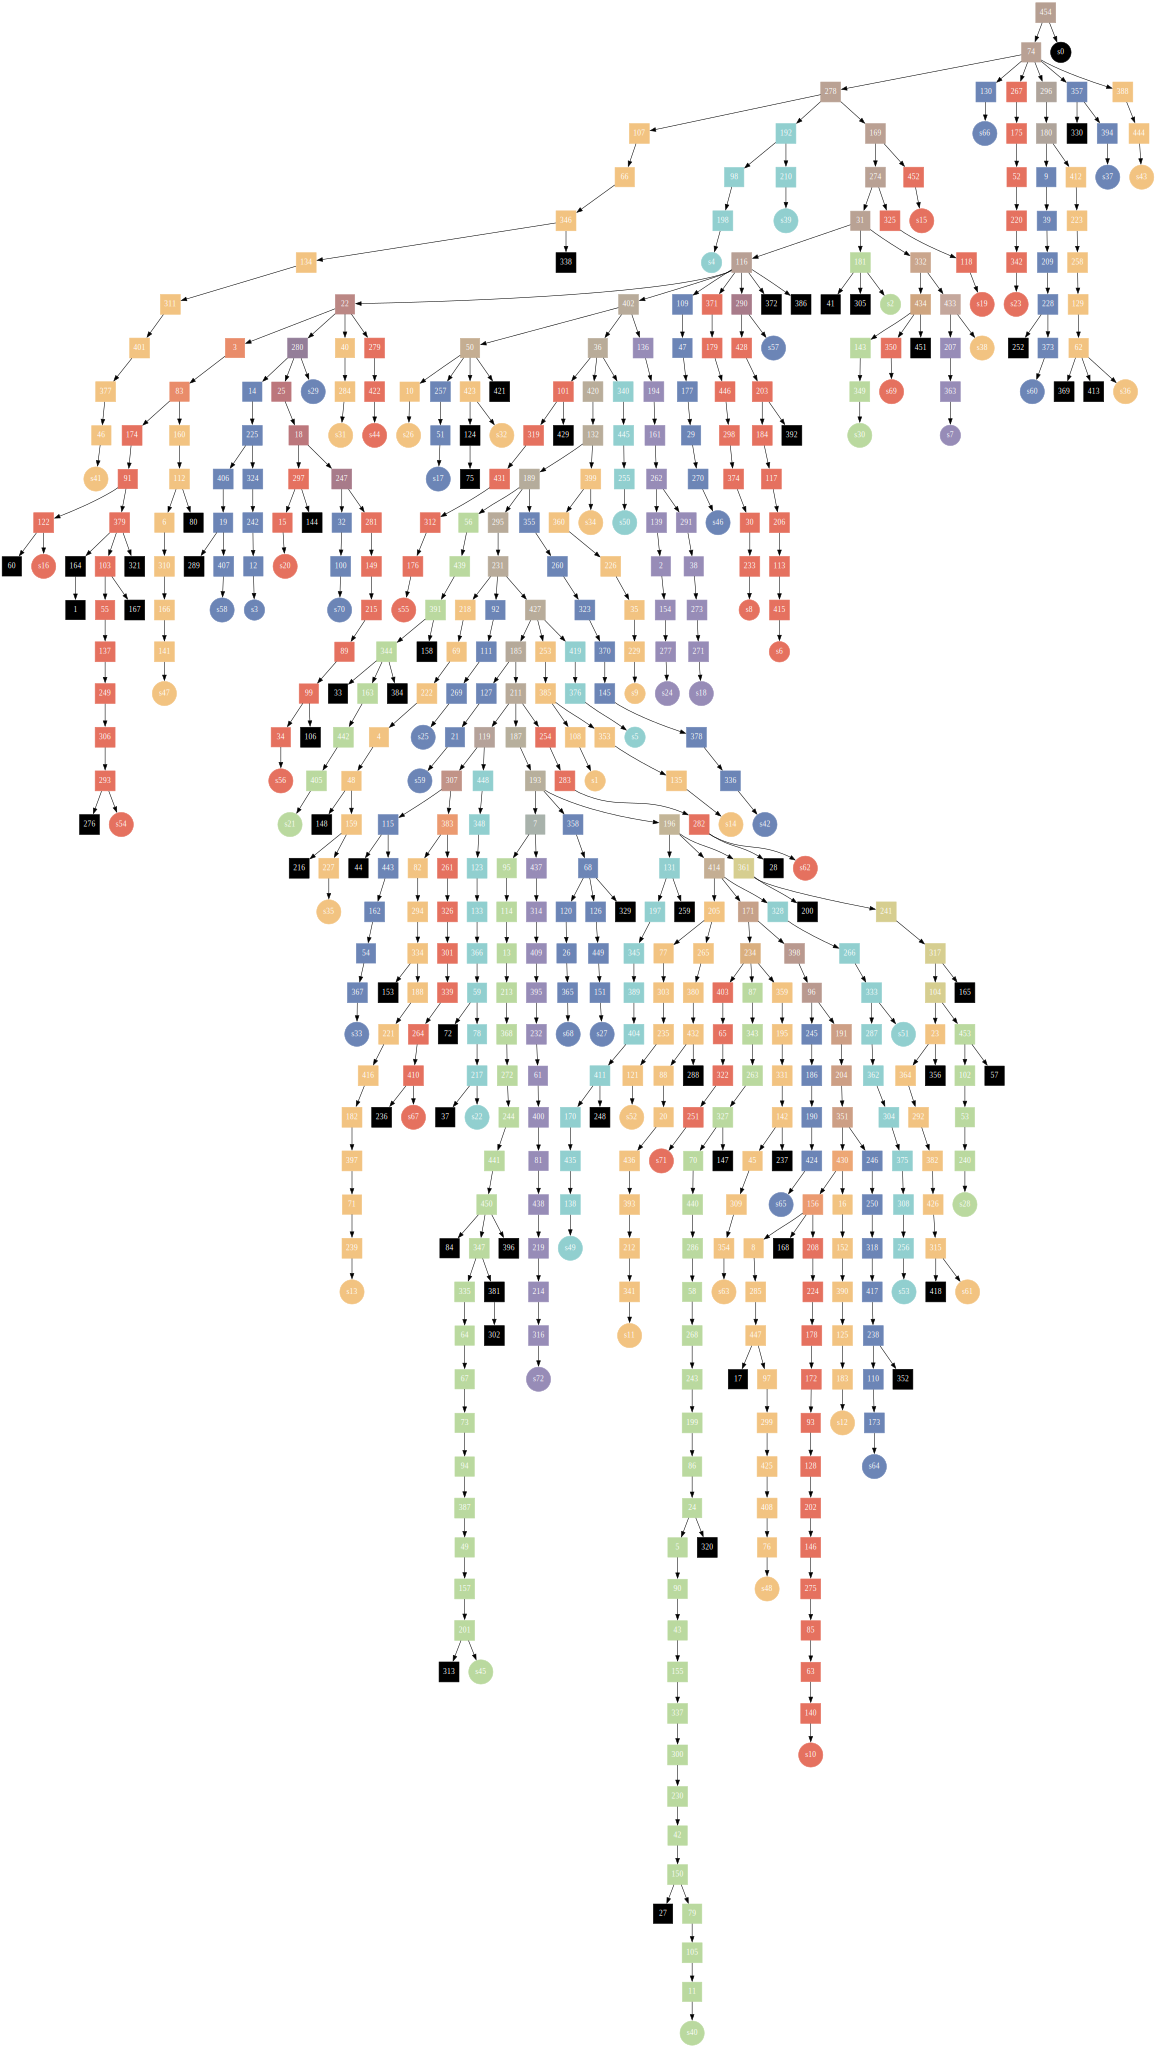

In [50]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)
g.layout('dot')
#g.draw(f'../../data/YFV2001_figs/pretty_trees/0.0556_map0.pdf')
Source(g)